<h1><center> Stock News Webscrape </h1>

<h3><center> Goal Of Notebook: </h3>

<p><center> To be able to webscrape a stock's news from Yahoo Finance </p>

In [1]:
'''
Importing the neccesary libraries
'''
import pandas as pd
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re 
from datetime import datetime
import urllib
import urllib.request
import requests

### Introducing Beautiful Soup

<p> Beautiful Soup is a Python library for pulling data out of HTML. It will save us tremendous headaches. </p>

<p> Try it out by using a yahoo finance url and transforming the html to a bsObj. </p>

In [2]:
site = 'https://finance.yahoo.com'
html = urlopen(site) #urlopen grabs the html
bsObj = BeautifulSoup(html) #BeautifulSoup is the class that transforms the html to a bsObj

<p> By the end of the notebook series, we will have a much larger function. The base of our much larger function starts with grabbing the links from our website that we want to dissect. To do so we begin with the function below called getStockLinks. It's pretty straight-forward to understand if you have a background in HTML. </p>

In [3]:
def getStockLinks(site, stock):
    '''
    Params:
    Website
    Stock
    ---------------------------------
    Function parses a url to find all of the a tags in the html
    From there it selects only the "a" tags where the stock is contained in the href link
    
    Only append links into our list of links if the link has not yet been appended
    '''
    internal_links = [] 
    html = urlopen(site) #Grabs the html
    bsObj = BeautifulSoup(html) #Converts the html to a bsObj
    for link in bsObj.findAll("a", href=re.compile('.*'+stock+'.*')): #Find the a tags where the stock is in the href attr
        link = link.attrs['href']
        if link.startswith(site) and link not in internal_links: #Straithforward code - if the link starts with site - no need to format it
                internal_links.append(link)
        elif link.startswith('https') == False:
            link = site+link #If the link does not start with the site, then string concatanete the site + the link
            if link not in internal_links:
                internal_links.append(link)
    return internal_links

<p> Wonderful, BeautifulSoup was able to grab the links related to our stock 'boeing', for this example. </p>

In [4]:
link_example = getStockLinks(site, 'boeing')
link_example

['https://finance.yahoo.com/news/boeing-went-appealing-government-aid-015541933.html',
 'https://finance.yahoo.com/m/f7936d03-e249-3f18-8895-9edd6439d950/boeing-avoids-bailout-after.html',
 'https://finance.yahoo.com/m/8289d36b-b2d2-3c48-835f-d86f8879e411/boeing-lands-25-billion-debt.html']

<p>Now, we want to send ourself an informative email. Links alone won't tell us much. So what can we add? </p> <p> The next step in detail is adding dates for each of our links.</p>
<p> In order to do so, we will have to loop through our links list from above. During each loop we will transform the html into a bsObj. From there we use the method find to find the corresponding html tag that holds the published time of the link. When its all said and done, the end of the function returns a mapping of the link to the time of publishment. </p>

In [5]:
def get_dates(links):
    '''
    Params:
    List of Links
    --------------------------------
    Create a dictionary mapping of links to date of publish
    
    First create a bsObj for each link in your link list
    Then use BeautifulSoup to find the tag related to the publish date/time
    
    As long as a date tag is found, use the get_text method to get the text related
    to that tag
    
    In the links_dict dictionary create a mapping from the link to the publish date
    making sure that the publish date is a datetime type
    '''
    links_dict = {}
    for link in links:
        urlopen = requests.get(link).text 
        bsObj = BeautifulSoup(urlopen, 'html.parser') #Convert the html to a bsObj
            
        date = bsObj.find('time') #time tag is used for the published time
        if date is not None:
            str_date = date.get_text() #Get the text associated with the time tag
            try:
                date = datetime.strptime(str_date, '%B %d, %Y')
            except:
                date = datetime.strptime('January 01, 2000' '%B %d, %Y')            
            links_dict[link] = date
    return links_dict

<p> Look at that, we were able to create a function that took our links, went inside of them and produced a mapping to the corresponding publish dates. </p>

In [6]:
get_dates(link_example)

{'https://finance.yahoo.com/news/boeing-went-appealing-government-aid-015541933.html': datetime.datetime(2020, 5, 2, 0, 0),
 'https://finance.yahoo.com/m/f7936d03-e249-3f18-8895-9edd6439d950/boeing-avoids-bailout-after.html': datetime.datetime(2020, 5, 1, 0, 0),
 'https://finance.yahoo.com/m/8289d36b-b2d2-3c48-835f-d86f8879e411/boeing-lands-25-billion-debt.html': datetime.datetime(2020, 4, 30, 0, 0)}

<p> Unfortuanetly, as you will see, is that every html is different. Yahoo finance happened to use the time tag to hold its publish date. This will not be the case for the other two websites we work in. </p>
<p> On top of that, the formatting of the dates will be different for each website. But, for the moment let's keep proceeding with yahoo finance. </p>

<p> A dictionary is not the prettiest thing to look at when receiving an email. What we can do instead is create a dataframe - or table in html, to help design a better looking email. While doing that we will convert the datetime datatype to a much more readable datetime using the strftime method. </p>

In [7]:
def links_dataframe(links, website):
    '''
    Params:
    List of links
    ------------------------------------
    Create a links dataframe with columns labeled as URL and Published Time
    
    Because the published time is a datetime datatype it is easy to sort with
    Then create a standard datetime format for all links
    '''
    links_dict = get_dates(links)
    if len(links_dict) != 0:
        links_df = pd.DataFrame(list(links_dict.items()), columns=['URL', 'Published Time'])
        links_df.columns.name = site
        links_df.sort_values(by =['Published Time'], ascending=False, inplace=True) #Descend the dates
        links_df['Published Time'] = links_df['Published Time'].dt.strftime('%b %d, %Y %I:%M %p') #strftime shifts the datetime date to our applied format
        return links_df
    else:
        links_df = pd.DataFrame(list(links_dict.items()), columns=['URL', 'Published Time'])
        return links_df

<p> Notice how we changed the published time format again. This will be the datetime format we will be using for the other two websites as well. </p>

In [8]:
links_dataframe(link_example, site)

https://finance.yahoo.com,URL,Published Time
0,https://finance.yahoo.com/news/boeing-went-app...,"May 02, 2020 12:00 AM"
1,https://finance.yahoo.com/m/f7936d03-e249-3f18...,"May 01, 2020 12:00 AM"
2,https://finance.yahoo.com/m/8289d36b-b2d2-3c48...,"Apr 30, 2020 12:00 AM"


## Converting our functions into a StockInfo class

<p> It's always good practice to store data using classes. Instead of using lists and dictionaries that happen to contain all your data you can keep all of it under one roof, which makes accessing and passing these objects around much more convenient. </p>

<p> Note: I added try except statements to the get_dates methods as Yahoo Finance website could always change. </p>

In [9]:
class StockInfo:
    def __init__(self, stock):
        '''
        Params: URL - Site where to grab data
        Stock - Keyword to query by
        '''
        self.url = 'https://finance.yahoo.com'
        self.stock = stock
        
    def getStockLinks(self):
        '''
        Params:
        Website
        Stock
        ---------------------------------
        Function parses a url to find all of the a tags in the html
        From there it selects only the "a" tags where the stock is contained in the href link

        Only append links into our list of links if the link has not yet been appended
        '''
        site = self.url
        stock = self.stock
        self.internal_links = [] 
        html = urlopen(site)
        bsObj = BeautifulSoup(html)
        for link in bsObj.findAll("a", href=re.compile('.*'+stock+'.*')):
            link = link.attrs['href']
            if link.startswith(site) and link not in self.internal_links: #Straithforward code - if the link starts with site - no need to format it
                    self.internal_links.append(link)
            elif link.startswith('https') == False:
                link = site+link #If the link does not start with the site, then string concatanete the site + the link
                if link not in self.internal_links:
                    self.internal_links.append(link)
        return self.internal_links

    def get_dates(self):
        '''
        Params:
        List of Links
        --------------------------------
        Create a dictionary mapping of links to date of publish

        First create a bsObj for each link in your link list
        Then use BeautifulSoup to find the tag related to the publish date/time

        As long as a date tag is found, use the get_text method to get the text related
        to that tag

        In the links_dict dictionary create a mapping from the link to the publish date
        making sure that the publish date is a datetime type
        '''
        links = self.getStockLinks()
        self.links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text
                bsObj = BeautifulSoup(urlopen, 'html.parser')

                date = bsObj.find('time')
                if date is not None:
                    str_date = date.get_text()
                    try:
                        date = datetime.strptime(str_date, '%B %d, %Y')
                    except:
                        date = datetime.strptime('January 01, 2000' '%B %d, %Y')
                    self.links_dict[link] = date
        except:
            pass
        return self.links_dict

    def links_dataframe(self):
        '''
        Params:
        List of links
        ------------------------------------
        Create a links dataframe with columns labeled as URL and Published Time

        Because the published time is a datetime datatype it is easy to sort with
        Then create a standard datetime format for all links
        '''
        self.links_dict = self.get_dates()
        if len(self.links_dict) != 0:
            self.links_df = pd.DataFrame(list(self.links_dict.items()), columns=['URL', 'Published Time'])
            self.links_df.columns.name = self.url
            self.links_df.sort_values(by =['Published Time'], ascending=False, inplace=True)
            self.links_df['Published Time'] = self.links_df['Published Time'].dt.strftime('%b %d, %Y %I:%M %p')
            return self.links_df
        else:
            self.links_df = pd.DataFrame(list(self.links_dict.items()), columns=['URL', 'Published Time'])
            return self.links_df

    

<p> To create instances of a class, you call the class using class name and pass in whatever arguments its __init__ method accepts. </p>

In [10]:
boeing = StockInfo('boeing')

<p> Notice now we can retrieve the url attribute from our object. </p>

In [11]:
boeing.url

'https://finance.yahoo.com'

<p> And here is the stock attribute from our object. </p>

In [12]:
boeing.stock

'boeing'

<p> Now let's call the getStockLinks method, remember it takes no parameters. In order to call it, however, make sure to include (). </p>

In [13]:
boeing.getStockLinks()

['https://finance.yahoo.com/news/boeing-went-appealing-government-aid-015541933.html',
 'https://finance.yahoo.com/m/f7936d03-e249-3f18-8895-9edd6439d950/boeing-avoids-bailout-after.html',
 'https://finance.yahoo.com/m/8289d36b-b2d2-3c48-835f-d86f8879e411/boeing-lands-25-billion-debt.html']

In [14]:
boeing.get_dates()

{'https://finance.yahoo.com/news/boeing-went-appealing-government-aid-015541933.html': datetime.datetime(2020, 5, 2, 0, 0),
 'https://finance.yahoo.com/m/f7936d03-e249-3f18-8895-9edd6439d950/boeing-avoids-bailout-after.html': datetime.datetime(2020, 5, 1, 0, 0),
 'https://finance.yahoo.com/m/8289d36b-b2d2-3c48-835f-d86f8879e411/boeing-lands-25-billion-debt.html': datetime.datetime(2020, 4, 30, 0, 0)}

<p> Had we just wanted the links dataframe from the start, we can just call the links_dataframe() method. </p>

In [15]:
boeing.links_dataframe()

https://finance.yahoo.com,URL,Published Time
0,https://finance.yahoo.com/news/boeing-went-app...,"May 02, 2020 12:00 AM"
1,https://finance.yahoo.com/news/non-bailout-fed...,"May 02, 2020 12:00 AM"
2,https://finance.yahoo.com/news/boeing-opts-fed...,"May 01, 2020 12:00 AM"


<p> Here is proof you can simply call the links_df, bypassing the two other functions. </p>

In [16]:
boeing = StockInfo('boeing')
boeing.links_dataframe()

,URL,Published Time


## Defining a Send Mail Function

##### PLEASE NOTE YOU WILL HAVE TO CHANGE YOUR GMAIL SETTINGS IN ORDER TO RUN THIS FUNCTION

In [17]:
def send_mail(email, password, stockclass):
    '''
    Parameters:
    An email username
    An email password
    The stockclass object
    ------------------------------------
    Create a personalized email with the bulk of the html
    being about the links dataframe
    '''
    dataframe = stockclass.links_dataframe() #Main dataframe
    me = email #Email of sender
    you = email #Email of receiver - obviously we are sending an email to ourselves
    
    #Begin to build the message
    msg = MIMEMultipart('alternative')
    msg['Subject'] = "Link"
    msg['From'] = me
    msg['To'] = you

    #Begin formatting your html preferences
    html = html = """\
<html>
  <head> </head>
  <body>
  <h1>Hi John Smith, <br> Below is the news for {0} Stock On {1}</h1>
  <h2>Let me know if you want information for a different stock</h2>
  """.format(stockclass.stock.capitalize(), datetime.now().strftime('%B-%d-%Y') ) #Use format to have a flexible header
    
    html += '<h3>Here is {0} stock information from {1}<h3>'.format(stockclass.stock.capitalize(), dataframe.columns.name)
    dataframe_html  = dataframe.to_html() #Converts our table dataframe to html directly
    html += dataframe_html + '<br>'
    
    
    html += """
    </body>
</html>
"""
    part2 = MIMEText(html,'html') #part one was the subject, from, to

    #Below are the neccessary mail configurations
    msg.attach(part2)
    mail = smtplib.SMTP('smtp.gmail.com', 587)
    mail.ehlo()
    mail.starttls()
    mail.login(email, password)
    mail.sendmail(me, you, msg.as_string())
    mail.quit()


<p> Now we begin to utilize our email function. </p>

In [18]:
boeing = StockInfo('boeing')

In [19]:
email = 'paulstocknews@gmail.com'
send_mail('<email>','<password>', boeing)

<p> Below is the email I received. </p>

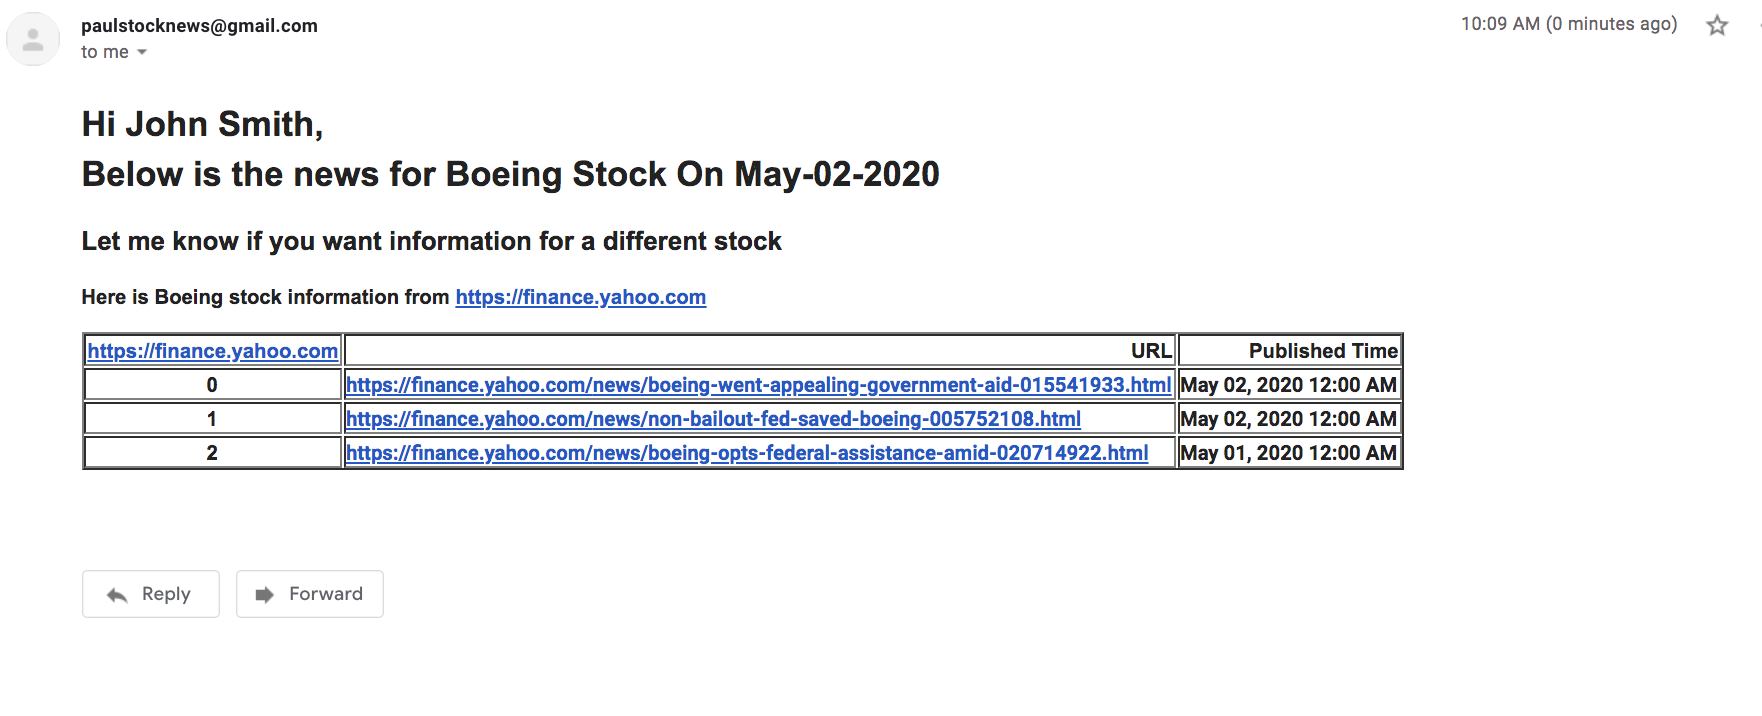

In [20]:
from IPython.display import Image
Image(filename="/Users/paulvicks/Documents/boeingproof.png")

<h1> <center> Putting it all together </h1></center>

## Combining all of our functions into one StockInfo Class

<p> From here, you can design a script however you'd like. </p>
<p> I added some additional modifications to smother some bugs. Try and except statements where added. </p>

In [21]:
class StockInfo:
    def __init__(self, stock):
        '''
        Params: URL - Site where to grab data
        Stock - Keyword to query by
        '''
        self.url = 'https://finance.yahoo.com'
        self.stock = stock
        
    def getStockLinks(self):
        '''
        Params:
        Website
        Stock
        ---------------------------------
        Function parses a url to find all of the a tags in the html
        From there it selects only the "a" tags where the stock is contained in the href link

        Only append links into our list of links if the link has not yet been appended
        '''
        site = self.url
        stock = self.stock
        self.internal_links = [] 
        html = urlopen(site)
        bsObj = BeautifulSoup(html)
        for link in bsObj.findAll("a", href=re.compile('.*'+stock+'.*')): #check to see if stock in href
            link = link.attrs['href'] #grab the link
            if link.startswith(site) and link not in self.internal_links: #Straithforward code - if the link starts with site - no need to format it
                    self.internal_links.append(link)
            elif link.startswith('https') == False:
                link = site+link #If the link does not start with the site, then string concatanete the site + the link
                if link not in self.internal_links:
                    self.internal_links.append(link)
        return self.internal_links

    def get_dates(self):
        '''
        Params:
        List of Links
        --------------------------------
        Create a dictionary mapping of links to date of publish

        First create a bsObj for each link in your link list
        Then use BeautifulSoup to find the tag related to the publish date/time

        As long as a date tag is found, use the get_text method to get the text related
        to that tag

        In the links_dict dictionary create a mapping from the link to the publish date
        making sure that the publish date is a datetime type
        '''
        links = self.getStockLinks()
        self.links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text
                bsObj = BeautifulSoup(urlopen, 'html.parser')

                date = bsObj.find('time') #find the time tags
                if date is not None:
                    str_date = date.get_text() #Get the text associated
                    try:
                        date = datetime.strptime(str_date, '%B %d, %Y') #Convert the date to datetime
                    except:
                        date = datetime.strptime('January 01, 2000', '%B %d, %Y')
                    self.links_dict[link] = date
        except:
            pass
        return self.links_dict

    def links_dataframe(self):
        '''
        Params:
        List of links
        ------------------------------------
        Create a links dataframe with columns labeled as URL and Published Time

        Because the published time is a datetime datatype it is easy to sort with
        Then create a standard datetime format for all links
        '''
        self.links_dict = self.get_dates()
        if len(self.links_dict) != 0:
            self.links_df = pd.DataFrame(list(self.links_dict.items()), columns=['URL', 'Published Time']) #our two columns
            self.links_df.columns.name = self.url
            self.links_df.sort_values(by =['Published Time'], ascending=False, inplace=True) #order datetimes in descending order
            self.links_df['Published Time'] = self.links_df['Published Time'].dt.strftime('%b %d, %Y %I:%M %p') #the format of our datetimes
            return self.links_df
        else:
            self.links_df = pd.DataFrame(list(self.links_dict.items()), columns=['URL', 'Published Time']) #empty datafrmae if links_dict is empty
            return self.links_df
    
    def send_mail(self, email, password):
        '''
        Parameters:
        An email username
        An email password
        The stockclass object
        ------------------------------------
        Create a personalized email with the bulk of the html
        being about the links dataframe
        '''
        dataframe = self.links_dataframe() #Main dataframe
        me = email #Email of sender
        you = email #Email of receiver - obviously we are sending an email to ourselves

        #Begin to build the message
        msg = MIMEMultipart('alternative')
        msg['Subject'] = "Link"
        msg['From'] = me
        msg['To'] = you

        #Begin formatting your html preferences
        html = html = """\
    <html>
      <head> </head>
      <body>
      <h1>Hi John Smith, <br> Below is the news for {0} Stock On {1}</h1>
      <h2>Let me know if you want information for a different stock</h2>
      """.format(self.stock.capitalize(), datetime.now().strftime('%B-%d-%Y') ) #Use format to have a flexible header

        html += '<h3>Here is {0} stock information from {1}<h3>'.format(self.stock.capitalize(), dataframe.columns.name)
        dataframe_html  = dataframe.to_html() #Converts our table dataframe to html directly
        html += dataframe_html + '<br>'


        html += """
        </body>
    </html>
    """
        part2 = MIMEText(html,'html') #part one was the subject, from, to

        #Below are the neccessary mail configurations
        msg.attach(part2)
        mail = smtplib.SMTP('smtp.gmail.com', 587)
        mail.ehlo()
        mail.starttls()
        mail.login(email, password)
        mail.sendmail(me, you, msg.as_string())
        mail.quit()

<p> Below is how to call the send_mail method from our StockInfo Class. Replace email and password to yours. </p>

In [22]:
boeing = StockInfo('boeing')
boeing.send_mail('<email>', '<password>')

<h4> I will attach the link to the script version of this notebook below. I will also attach the next jupyter notebook to go through the process of creating a class that applies to more than one website. </h4>

<p>Script: https://github.com/pvicks585/stock_news/blob/master/stockinfo_yahoo.py </p>
<p>Next: https://github.com/pvicks585/stock_news/blob/master/StockWebscrape_multiple_websites.ipynb</p>